# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [240]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [241]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
import pickle
import math

#Set random seed
np.random.seed(1606)

### 1. Import Vectors and Pre-Process them

In [242]:
# Import vec file
with open('go-gofuncs.lst', 'r') as file:
    text = file.read()

In [243]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [244]:
df.head()

,ID,Vector
0,MESH:D012559,"[1.76247600e-02, -1.05403718e-02, -4.61959302e..."
1,MESH:D009404,"[0.01795662, 0.13640046, 0.03051887, -0.100085..."
2,MESH:D001749,"[-8.68742093e-02, 8.83234814e-02, -2.54237115e..."
3,MESH:D011471,"[-0.00926186, 0.04098112, -0.4911138, -0.22025..."
4,MESH:D008106,"[-0.12722802, 0.07976454, -0.5775048, -0.28237..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [245]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [246]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [247]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [248]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C028474,MESH:D006528,"[-0.08689959, 0.06080057, -0.04620415, -0.1237...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
1,C028474,MESH:D005355,"[-4.32693306e-03, 1.35906458e-01, -1.91942360e...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
2,C028474,MESH:D006529,"[-0.02542116, 0.0981225, -0.01938446, -0.14929...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
3,C028474,MESH:D006965,"[-0.01135238, 0.143319, 0.04601676, -0.1474806...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
4,C028474,MESH:D008114,"[-0.10265561, 0.03210206, -0.13152453, -0.0728...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1


In [249]:
len(id_list)

3137

In [250]:
chem_dis.shape

(8651, 2)

### Commenting out the below while I try to fit it in after phenotype section

In [251]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [252]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)   # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  8650
(17301, 5)
(17145, 5)


In [253]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### Add Phenotypes
Got a list of Chem-Phenotypes from Sara Alth, where did these come from originally?
They have CID identifiers (Pubchem). Need to convert CTD ID to CID ID
Use API like so 
http://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/Comparative%20Toxicogenomics%20Database/C533207/cids/TXT/

In [254]:
## First we'll add DOIDs for diseases and CIDs for chemicals as an intermediate for adding phenotypes
# Read in CSV mapping chems to CID and dis to DOID
mapper = pd.read_csv('entities.lst')

# Make the maps from this
dis_map = dict(zip(mapper.ID, mapper.DOID))
chem_map = dict(zip(mapper.ID, mapper.CID))

# Apply the maps to df1
df1['DOID'] = df1.DiseaseID.map(lambda x: dis_map.get(x))
df1['CID'] = df1.ChemicalID.map(lambda x: chem_map.get(x))

In [255]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID
1341,C017947,MESH:D008175,"[-0.0498087, 0.08013102, -0.21025404, -0.14221...","[-0.0531880707, 0.0433869548, -0.196800679, -0...",1,DOID:3905,443495.0
9741,C582340,MESH:D013617,"[0.05696682, 0.09369084, -0.0048688, -0.089769...","[0.03923435, 0.10083519, 0.0233496, -0.1123369...",0,NaN,NaN
8458,D014673,MESH:D007022,"[-0.07060508, 0.08438816, -0.0596953, -0.07784...","[0.0453479178, 0.138363615, -0.0531766899, -0....",1,NaN,39764.0


In [256]:
# Read in the association files from Sara
dis_phens = pd.read_csv('Disease-PhenotypeAssocation.txt', sep=' ', names=['DOID', 'Phenotype'])
chem_phens =  pd.read_csv('Drug-PhenotypeAssocation.txt', sep=' ', names=['CID', 'Phenotype'])

In [257]:
# The association files have a different format for each ID system than mine, homogenise these
# first chem
def cid_standardiser (cid):
    # Must be format CID + 9 int chars, starting with 1 seemingly
    cid = int(cid)
    output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return output

df1['CID'] = df1.CID.map(lambda x: np.nan if math.isnan(x) else cid_standardiser(x))

In [258]:
# and now disease 
def doid_standardiser (doid):
    # Must be format DOID_ + ...
    # I'm unsure about how well this is working so print out the DOIDs that don't match
    doid = doid.replace(':', '_')
#     output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return doid

df1['DOID'] = df1.DOID.map(lambda x: np.nan if isinstance(x, float) else doid_standardiser(x))

In [259]:
## Now that the DOIDs and CIDs are theoretically standardised we can chuck in the phens to df1

# First though check which DOIDs and CIDs do not match up --> SEEMS OK
# test_doids = df1[df1.DOID.map(lambda x: isinstance(x, str))].DOID.tolist()
# imported_doids = dis_phens.DOID.tolist()
# for item in test_doids:
#     if item not in imported_doids:
#         print(item)                            

### IAN!!! The below is dumb, forces max one phen per entity

In [260]:
# # Map DOIDs and CIDs to phens
# dis_map = dict(zip(dis_phens.DOID, dis_phens.Phenotype))
# chem_map = dict(zip(chem_phens.CID, chem_phens.Phenotype))

# df1['chemPhen'] = df1.CID.map(lambda x: chem_map.get(x, np.nan))
# df1['disPhen'] = df1.DOID.map(lambda x: dis_map.get(x, np.nan))

In [261]:
# df1.sample(2)

In [262]:
## Instead of the above two silly cells, just take the existing association files, opa2vec them and then integrate

In [263]:
# hp_dis = dis_phens['']

In [264]:
chem_phens.sample(3)

,CID,Phenotype
25763,CID100003397,<http://purl.obolibrary.org/obo/HP_0003074>
40673,CID100004259,<http://purl.obolibrary.org/obo/HP_0002910>
21420,CID100003168,<http://purl.obolibrary.org/obo/HP_0000822>


In [265]:
chem_phens.columns = ['ID', 'Phen']
dis_phens.columns = ['ID', 'Phen']

# Maps for Split into MP/HP
hp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))
hp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

total_hp = chem_phens[hp_df_crit_c].append(dis_phens[hp_df_crit_d], ignore_index=True)
total_mp = chem_phens[mp_df_crit_c].append(dis_phens[mp_df_crit_d], ignore_index=True)

In [266]:
# Alright now we have the phenotype links in df1. How do we turn them into feats? Vectorise with opa2vec
# Associations file: entity <ont_uri>
# First detect whether HP or MP

In [267]:
# # Maps for Split into MP/HP
# hp_df_crit_d = df1.disPhen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
# mp_df_crit_d = df1.disPhen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))
# hp_df_crit_c = df1.chemPhen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
# mp_df_crit_c = df1.chemPhen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

# # Make the split
# hp_df = df1[hp_df_crit_c | hp_df_crit_d]
# mp_df = df1[mp_df_crit_c | mp_df_crit_d]

In [268]:
# # MP
# # Create intermediate dfs of entity-phens
# chem_mp = mp_df[['ChemicalID', 'chemPhen']]
# dis_mp = mp_df[['DiseaseID', 'disPhen']]
# chem_mp.columns = ['ID', 'Phen']
# dis_mp.columns = ['ID', 'Phen']

# # Append into a total HP df, dropping nans and dupes
# total_mp = chem_mp.append(dis_mp,ignore_index=True).dropna().drop_duplicates()

In [269]:
# # HP
# # Create intermediate dfs of entity-phens
# chem_hp = hp_df[['ChemicalID', 'chemPhen']]
# dis_hp = hp_df[['DiseaseID', 'disPhen']]
# chem_hp.columns = ['ID', 'Phen']
# dis_hp.columns = ['ID', 'Phen']

# # Append into a total HP df, dropping nans and dupes
# total_hp = chem_hp.append(dis_hp,ignore_index=True).dropna().drop_duplicates()

In [270]:
total_hp.head()

,ID,Phen
0,CID100000085,<http://purl.obolibrary.org/obo/HP_0002027>
1,CID100000085,<http://purl.obolibrary.org/obo/HP_0002321>
2,CID100000085,<http://purl.obolibrary.org/obo/HP_0002013>
3,CID100000085,<http://purl.obolibrary.org/obo/HP_0004324>
4,CID100000085,<http://purl.obolibrary.org/obo/HP_0002321>


In [271]:
total_mp.head()

,ID,Phen
0,CID100000085,<http://purl.obolibrary.org/obo/MP_0005036>
1,CID100000085,<http://purl.obolibrary.org/obo/MP_0003360>
2,CID100000085,<http://purl.obolibrary.org/obo/MP_0001636>
3,CID100000085,<http://purl.obolibrary.org/obo/MP_0001363>
4,CID100000085,<http://purl.obolibrary.org/obo/MP_0001664>


In [272]:
np.savetxt(r'associations_hp.txt', total_hp.values, fmt='%s')
np.savetxt(r'associations_mp.txt', total_mp.values, fmt='%s')

print('Num HP associations: ', total_hp.shape[0])
print('Num MP associations: ', total_mp.shape[0])
print('Num ents with MP phen assocs: ', len(total_mp.ID.unique()))
print('Num ents with HP phen assocs: ', len(total_hp.ID.unique()))

Num HP associations:  277300
Num MP associations:  111742
Num ents with MP phen assocs:  8942
Num ents with HP phen assocs:  9126


In [273]:
# Create entities.lst to inform opa2vec which entities we want vectors for
entities = total_mp.ID.unique().tolist()
np.savetxt(r'entities_mp.lst', entities, fmt='%s')

entities = total_hp.ID.unique().tolist()
np.savetxt(r'entities_hp.lst', entities, fmt='%s')

### Run OPA2VEC for entity-phens

In [274]:
# HP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/hp.owl -associations ../msc-thesis/opa/associations_hp.txt -entities ../msc-thesis/opa/entities_hp.lst -outfile ../msc-thesis/opa/hpvecs.lst)', shell=True)

In [275]:
# # MP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/mp.owl -associations ../msc-thesis/opa/associations_mp.txt -entities ../msc-thesis/opa/entities_mp.lst -outfile ../msc-thesis/opa/mpvecs.lst)', shell=True)

In [276]:
# Now import and integrate the vecs
# Import vec file
with open('hpvecs.lst', 'r') as file:
    text = file.read()

In [277]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
hp_vecs = pd.DataFrame(text)
hp_vecs.columns = ['ID', 'Vector']

# Clean
hp_vecs = hp_vecs.dropna()
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.split(','))

In [278]:
# Now import and integrate the vecs
# Import vec file
with open('mpvecs.lst', 'r') as file:
    text = file.read()

In [279]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
mp_vecs = pd.DataFrame(text)
mp_vecs.columns = ['ID', 'Vector']

# Clean
mp_vecs = mp_vecs.dropna()
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.split(','))

In [280]:
mp_vecs.head()

,ID,Vector
0,CID100000085,"[3.01051307e-02, 1.17277764e-01, 6.71188831e-0..."
1,CID100000119,"[0.01998051, 0.0986239, 0.05801483, -0.0928011..."
2,CID100000137,"[0.02992197, 0.12169582, 0.05783004, -0.120305..."
3,CID100000143,"[0.01803144, 0.11776197, 0.05759127, -0.102258..."
4,CID100000158,"[0.03986294, 0.13364626, 0.07320309, -0.121633..."


In [281]:
# Right, now I have hp and mp vecs, match them up into df1

In [282]:
df1.sample(2)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID
7134,D012601,MESH:D020326,"[0.0104571152, 0.111717328, 0.0554624461, -0.1...","[0.02786832, 0.1189471, 0.05839422, -0.1027873...",1,DOID_12783,CID103000322
2073,D002104,MESH:D005355,"[-0.00432693306, 0.135906458, -0.019194236, -0...","[0.00831776671, 0.130732596, 0.0683802217, -0....",1,NaN,CID100023973


In [283]:
# Make Maps:
mp_ent_to_vec = dict(zip(mp_vecs.ID, mp_vecs.Vector))
hp_ent_to_vec = dict(zip(hp_vecs.ID, hp_vecs.Vector))

# Map entities to vecs (one set of vecs for mp and another for hp)
df1['disPhenVecMP'] = df1.DOID.map(lambda x: mp_ent_to_vec.get(x))
df1['disPhenVecHP'] = df1.DOID.map(lambda x: hp_ent_to_vec.get(x))

df1['chemPhenVecHP'] = df1.CID.map(lambda x: hp_ent_to_vec.get(x))
df1['chemPhenVecMP'] = df1.CID.map(lambda x: mp_ent_to_vec.get(x))

In [284]:
df1.sample(4)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP
14690,D014640,OMIM:614167,"[0.0193723086, 0.0951790512, 0.0403853469, -0....","[-0.206336826, 0.0576904565, -0.497545689, -0....",0,NaN,CID100014969,None,None,None,None
12286,D006220,MESH:C537330,"[-0.00241984101, 0.118475705, 0.0549288988, -0...","[0.0164891388, 0.114317887, 0.0499765202, -0.1...",0,NaN,CID100003559,None,None,"[0.04922255, 0.16581932, 0.06299368, -0.100418...","[0.04149419, 0.13723436, 0.07005556, -0.133053..."
12488,D013654,OMIM:617336,"[0.03034971, 0.11276384, 0.03293004, -0.117591...","[0.01845004, 0.12686491, 0.05062994, -0.124328...",0,NaN,CID100001123,None,None,None,None
3596,D001335,MESH:D002583,"[-0.05149044, -0.02528337, -0.15345655, -0.049...","[-0.00130894, -0.11977076, -0.4671642, -0.1142...",1,DOID_4362,NaN,"[3.24608460e-02, 1.49750531e-01, 7.05482066e-0...","[0.04460038, 0.1486565, 0.07248612, -0.1180548...",None,None


In [285]:
## TODO note that I have removed rows without gofuncVecs, maybe now they should be kept
# Print Stats
print('Number of rows with gofuncs: ', df1.shape[0]) ##NB change this if keeping rows w/o gofunc vecs
print('Number of rows with dis mp vec: ', df1[df1.disPhenVecMP.map(lambda x: x is not None)].shape[0])
print('Number of rows with dis hp vec: ', df1[df1.disPhenVecHP.map(lambda x: x is not None)].shape[0])
print('Number of rows with chem mp vec: ', df1[df1.chemPhenVecMP.map(lambda x: x is not None)].shape[0])
print('Number of rows with chem hp vec: ', df1[df1.chemPhenVecHP.map(lambda x: x is not None)].shape[0])
no_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is None) & df1.disPhenVecMP.map(lambda x: x is None)
no_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is None) & df1.chemPhenVecMP.map(lambda x: x is None)
no_phen_vecs = no_dis_phen_vecs & no_chem_phen_vecs
print('Number of rows with no phen vecs: ', df1[no_phen_vecs].shape[0])
all_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is not None) & df1.disPhenVecMP.map(lambda x: x is not None)
all_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is not None) & df1.chemPhenVecMP.map(lambda x: x is not None)
all_vecs = all_dis_phen_vecs & all_chem_phen_vecs
print('Number of rows with everything', df1[all_vecs].shape[0])

Number of rows with gofuncs:  17145
Number of rows with dis mp vec:  7079
Number of rows with dis hp vec:  7088
Number of rows with chem mp vec:  2770
Number of rows with chem hp vec:  2846
Number of rows with no phen vecs:  8529
Number of rows with everything 1279


In [286]:
# Problem is that we're adding the uncorrelated rows pre adding phen vecs
# df1[df1.Correlation == 1].shape[0]

In [287]:
# Alright now that I have the vecs how to test?
# First run NN on only rows that have all vecs (but using only gofuncvec) then run with also phen vecs and compare
# If that's an improvement try running all obs with only gofuncvecs and then with phen/noise vecs

In [288]:
print(df1.shape)
# df1 = df1[all_vecs]
# df1 = df1[df1.Correlation == 1]
print(df1.shape)

(17145, 11)
(17145, 11)


In [289]:
# Add empty vecs for rows that don't have phen vecs
empty_vec = [0] * 200

for col in ['disPhenVecMP', 'disPhenVecHP', 'chemPhenVecHP', 'chemPhenVecMP']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [290]:
# Add empty vecs to any empty cell
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP
3611,D001335,MESH:D011009,"[-0.0232257098, 0.10661649, -0.00996672269, -0...","[-0.00130894, -0.11977076, -0.4671642, -0.1142...",1,DOID_10316,NaN,"[3.02922484e-02, 1.25827417e-01, 6.36174455e-0...","[5.33619821e-02, 1.49534836e-01, 5.61988726e-0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3346,D014028,MESH:D029424,"[-0.0465751514, 0.091544494, -0.0505495779, -0...","[0.0105292061, -0.0366925858, -0.351593316, -0...",1,DOID_3083,NaN,"[0.03889346, 0.12780632, 0.07175923, -0.120676...","[0.05873028, 0.14349952, 0.06206892, -0.118975...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5453,D015034,MESH:D015431,"[-0.10226419, 0.02348286, -0.19309644, -0.0882...","[-0.0693841279, 0.0243639816, -0.338837117, -0...",1,NaN,CID100014806,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [291]:
# # Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
# dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
# chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

# df_chems = df[chems]
# df_dis = df[dis]
# df_chems = df_chems.reset_index(drop=True)
# df_dis = df_dis.reset_index(drop=True)

In [292]:
# # Add unrelated pairs to df1
# no_rows = (df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
# print('shape: ', no_rows)

# # Randomly select chems and diseases (as many as there are related pairs)
# no_chems = len(df_chems) -1
# no_dis = len(df_dis) -1
# rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# # Add the new pairs as rows
# for x in range(0, no_rows):
#     int1 = rand_chems[x]
#     int2 = rand_dis[x]
#     chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
#     dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
#     df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

# print(df1.shape)
# # Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
# df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
# print(df1.shape)

In [293]:
print(df1.shape)
print(df1[df1.disPhenVecHP.map(lambda x: type(x) is not list) ].shape)

(17145, 11)
(0, 11)


In [294]:
# # Now add phenvecs to the controls...most controls probably won't have vecs
# # Map entities to vecs (one set of vecs for mp and another for hp)
# df1['disPhenVecMP'] = df1.DOID.map(lambda x: mp_ent_to_vec.get(x))
# df1['disPhenVecHP'] = df1.DOID.map(lambda x: hp_ent_to_vec.get(x))

# df1['chemPhenVecHP'] = df1.CID.map(lambda x: hp_ent_to_vec.get(x))
# df1['chemPhenVecMP'] = df1.CID.map(lambda x: mp_ent_to_vec.get(x))

In [295]:
print(df1.shape)
print(df1[df1.disPhenVecHP.map(lambda x: type(x) is not list) ].shape)
print(df1[df1.Correlation.map(lambda x: x == 1) ].shape)

(17145, 11)
(0, 11)
(8595, 11)


In [296]:
### TODO Ian you need to add phen vecs to controls

In [297]:
df1.sample(2)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP
12877,D013806,MESH:C565746,"[0.00641543, 0.13036917, 0.05680599, -0.116005...","[-0.0293051, 0.05801031, -0.04902449, -0.17032...",0,NaN,CID100002153,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06227177, 0.135282, 0.05029951, -0.08980234...","[3.13887633e-02, 1.45136625e-01, 6.59458935e-0..."
16186,C009006,MESH:D006967,"[0.02560887, 0.12163252, 0.01495632, -0.130699...","[-0.0008438, 0.11069649, 0.04016464, -0.128645...",0,DOID_1205,CID100516900,"[2.63199639e-02, 1.33038953e-01, 6.67358190e-0...","[0.0482741, 0.16627155, 0.06475095, -0.1247241...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [298]:
# df1[df1.disPhenVecHP.map(lambda x: type(x) is not list)].sample(3)

In [299]:
# Change the vec elements from string to floats
df1['disPhenVecHP'] = df1.disPhenVecHP.map(lambda x: [float(i) for i in x])
df1['disPhenVecMP'] = df1.disPhenVecMP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecHP'] = df1.chemPhenVecHP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecMP'] = df1.chemPhenVecMP.map(lambda x: [float(i) for i in x])

In [300]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

all_X = np.array(all_X)

In [301]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [302]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (17145,)
X shape:  (17145, 1200)


In [303]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [304]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  570
number of dis:  2501
342 114 114


In [305]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [306]:
# Split by CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

number of chemicals:  570
number of dis:  2501


In [307]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

10534 3312 3299


In [308]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

### 3. Establish NN Model

In [309]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [310]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [311]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [312]:
# 3. Train
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 10534 samples, validate on 3299 samples
Epoch 1/10
10534/10534 [==============================] - 2s 192us/step - loss: 0.5389 - acc: 0.7330 - val_loss: 0.5033 - val_acc: 0.7602
Epoch 2/10
10534/10534 [==============================] - 2s 164us/step - loss: 0.4984 - acc: 0.7640 - val_loss: 0.4798 - val_acc: 0.7799
Epoch 3/10
10534/10534 [==============================] - 2s 163us/step - loss: 0.4848 - acc: 0.7700 - val_loss: 0.4949 - val_acc: 0.7663
Epoch 4/10
10534/10534 [==============================] - 2s 190us/step - loss: 0.4677 - acc: 0.7869 - val_loss: 0.4809 - val_acc: 0.7790
Epoch 5/10
10534/10534 [==============================] - 2s 171us/step - loss: 0.4608 - acc: 0.7909 - val_loss: 0.4680 - val_acc: 0.7857
Epoch 6/10
10534/10534 [==============================] - 2s 171us/step - loss: 0.4527 - acc: 0.7942 - val_loss: 0.5137 - val_acc: 0.7596
Epoch 7/10
10534/10534 [==============================] - 2s 176us/step - loss: 0.4455 - acc: 0.7987 - val_loss: 0.4944 - v

### ...and evaluate

In [313]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3312/3312 [==============================] - 0s 71us/step
Test accuracy: 0.7910628019323671


In [314]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       1380   344     1724
True         348  1240     1588
__all__     1728  1584     3312


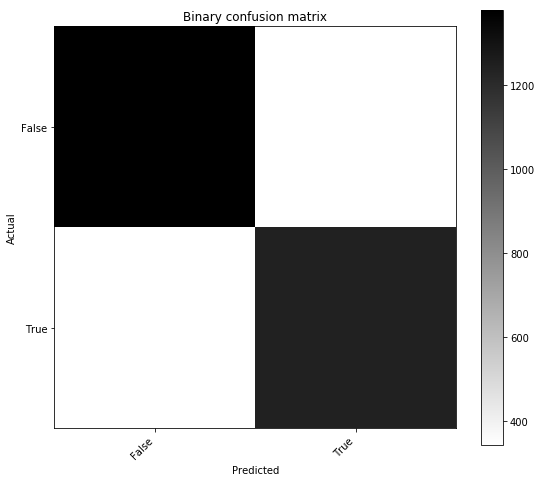

In [315]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [316]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8606347197952158


In [317]:
# Error out to stop notebook
for a in i
def 


SyntaxError: invalid syntax (<ipython-input-317-440e5fd394b4>, line 2)

### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# test_set.DiseaseID.nunique()

In [ ]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    print(col,  df_cd.columns)
    if str(col) in df_cd.columns: print('sd') # df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')

In [ ]:
mem_usage(df_cd)

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
# lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
# del lst
# test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
# for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
#     if col in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
#     if col in test_set.columns: test_set[col] = test_set[col].astype('category')

test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
type(df_cd.ChemicalID[1])

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions']].to_csv('predictions.csv', index=False)

In [ ]:
test_set.head()

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

In [ ]:
test_set.head()

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similarity

In [ ]:
# df1.head()

In [ ]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)